Found 6 contours


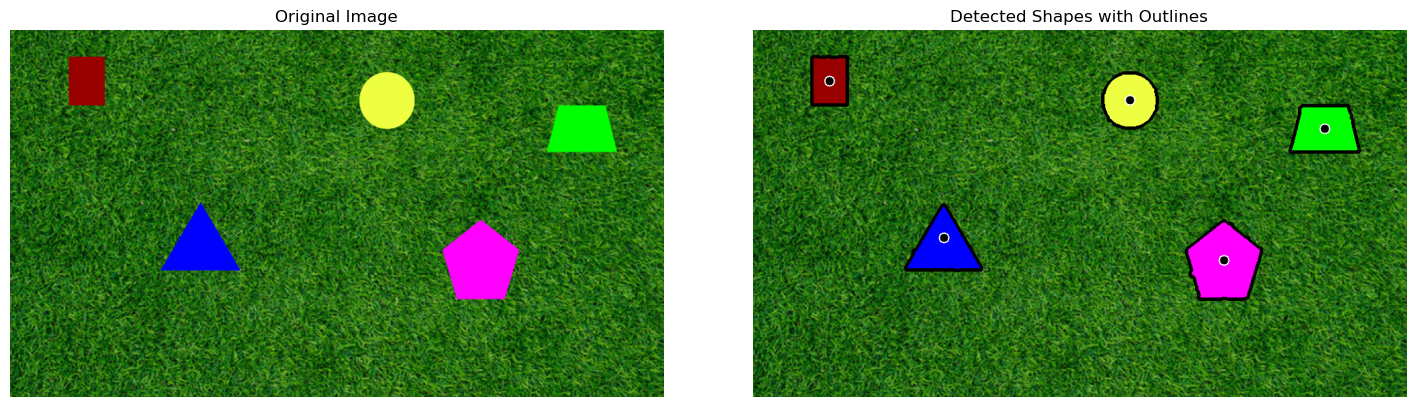


Total shapes detected: 5


In [2]:
#Part 1 - Static Image Algorithm & Image Display

#importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

#loading image
img = cv2.imread('/Users/ishabhatia/Downloads/PennAir 2024 App Static.png')

#making a copy to edit
img_copy = img.copy()
    
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#defining color recognition - tried converting to grayscale, didn't work
color_ranges = {
    'red': [(np.array([0, 120, 70]), np.array([10, 255, 255])),
                (np.array([170, 120, 70]), np.array([180, 255, 255]))],  
    'blue': [(np.array([100, 150, 50]), np.array([130, 255, 255]))],
    'yellow': [(np.array([15, 80, 80]), np.array([35, 255, 255]))],  
    'bright_green': [(np.array([50, 150, 150]), np.array([80, 255, 255]))],
    'pink': [(np.array([140, 100, 100]), np.array([170, 255, 255]))]
}

#creating a combined mask for all shape colors
combined_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
    
for color_name, ranges in color_ranges.items():
    if color_name == 'green':  # skip green b/c the grass is the background
        continue
            
    color_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
        
    for lower, upper in ranges:
        mask = cv2.inRange(hsv, lower, upper)
        color_mask = cv2.bitwise_or(color_mask, mask)
        
    #adding to combined mask    
    combined_mask = cv2.bitwise_or(combined_mask, color_mask)

#cleaning up the mask
kernel = np.ones((5,5), np.uint8)
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

#find contours that exist in the image
contours, hierarchy = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
print(f"Found {len(contours)} contours")

#processing each contour (shape) found
for i, contour in enumerate(contours):
    #filtering out very small contours 
    area = cv2.contourArea(contour)
    if area < 500:  
        continue
            
    #approximating the contour    
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
        
    #drawing the contour    
    cv2.drawContours(img_copy, [contour], -1, (0, 0, 0), 4)  # Black outline
        
    #getting the bounding rectangle    
    x, y, w, h = cv2.boundingRect(approx)
    x_mid = int(x + w/2)
    y_mid = int(y + h/2)
        
    #drawing the center point    
    cv2.circle(img_copy, (x_mid, y_mid), 8, (255, 255, 255), -1)  # white center point
    cv2.circle(img_copy, (x_mid, y_mid), 6, (0, 0, 0), -1)  # black inner point
        
    #identifying shape based on number of vertices - not necessary, but a good addition to have in order to be able to recognize the type of shape    
    vertices = len(approx)
    shape_name = "Unknown"
    if vertices == 3:
        shape_name = "Triangle"
    elif vertices == 4:
        # Check if it's square or rectangle
        aspect_ratio = float(w)/h
        if 0.85 <= aspect_ratio <= 1.15:
            shape_name = "Square"
        else:
            shape_name = "Rectangle"
    elif vertices == 5:
        shape_name = "Pentagon"
    elif vertices > 7: #circles get approximated with many vertices 
        shape_name = "Circle"
    else:
        shape_name = f"{vertices}-sided polygon"
        
    #detecting the color of the shape - also not necessary, but good to have if ever want to pull what color each shape is    
    mask_single = np.zeros(hsv.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_single, [contour], 255)
    mean_hsv = cv2.mean(hsv, mask=mask_single)
        
    detected_color = "Unknown"
    h_val = mean_hsv[0]
    s_val = mean_hsv[1]
    v_val = mean_hsv[2]
        
    if s_val > 100:  
        if (h_val < 10 or h_val > 170) and v_val > 100:
            detected_color = "Red"
        elif 20 < h_val < 30:
            detected_color = "Yellow"
        elif 100 < h_val < 130:
            detected_color = "Blue"
        elif 40 < h_val < 80:
            detected_color = "Green"
        elif 140 < h_val < 170:
            detected_color = "Pink"
            
#converting BGR to RGB for matplotlib display        
img_rgb_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb_result = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

#displaying images
plt.figure(figsize=(15, 8))
    
plt.subplot(2, 2, 1)
plt.imshow(img_rgb_original)
plt.title('Original Image')
plt.axis('off')
    
plt.subplot(2, 2, 2)
plt.imshow(img_rgb_result)
plt.title('Detected Shapes with Outlines')
plt.axis('off')
    
plt.tight_layout()
plt.show()
    
print(f"\nTotal shapes detected: {len([c for c in contours if cv2.contourArea(c) >= 500])}")

In [22]:
#Part 2 - Applying Algorithm to Video 

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, display, HTML
import os

#defining algorithm used for static image as a function that runs by frame
def detect_shapes_in_frame(frame):
    frame_copy = frame.copy()
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'red': [(np.array([0, 120, 70]), np.array([10, 255, 255])),
                (np.array([170, 120, 70]), np.array([180, 255, 255]))],  
        'blue': [(np.array([100, 150, 50]), np.array([130, 255, 255]))],
        'yellow': [(np.array([15, 80, 80]), np.array([35, 255, 255]))],  
        'bright_green': [(np.array([50, 150, 150]), np.array([80, 255, 255]))],
        'pink': [(np.array([140, 100, 100]), np.array([170, 255, 255]))]
    }

    combined_mask = np.zeros(hsv.shape[:2], dtype = np.uint8)

    for color_name, ranges in color_ranges.items():
        if color_name == 'green':  
            continue
                
        color_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
            
        for lower, upper in ranges:
            mask = cv2.inRange(hsv, lower, upper)
            color_mask = cv2.bitwise_or(color_mask, mask)
            
        combined_mask = cv2.bitwise_or(combined_mask, color_mask)
    
    kernel = np.ones((5,5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    
    contours, hierarchy = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    frame_shapes = []
    
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < 500:  
            continue
                
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
            
        cv2.drawContours(frame_copy, [contour], -1, (0, 0, 0), 4)  # Black outline
            
        x, y, w, h = cv2.boundingRect(approx)
        x_mid = int(x + w/2)
        y_mid = int(y + h/2)
            
        cv2.circle(frame_copy, (x_mid, y_mid), 8, (255, 255, 255), -1)  # white center point
        cv2.circle(frame_copy, (x_mid, y_mid), 6, (0, 0, 0), -1)  # black inner point
            
        vertices = len(approx)
        shape_name = "Unknown"
        if vertices == 3:
            shape_name = "Triangle"
        elif vertices == 4:
            # Check if it's square or rectangle
            aspect_ratio = float(w)/h
            if 0.85 <= aspect_ratio <= 1.15:
                shape_name = "Square"
            else:
                shape_name = "Rectangle"
        elif vertices == 5:
            shape_name = "Pentagon"
        elif vertices > 7: # circles get approximated with many vertices 
            shape_name = "Circle"
        else:
            shape_name = f"{vertices}-sided polygon"
            
        mask_single = np.zeros(hsv.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask_single, [contour], 255)
        mean_hsv = cv2.mean(hsv, mask=mask_single)
            
        detected_color = "Unknown"
        h_val = mean_hsv[0]
        s_val = mean_hsv[1]
        v_val = mean_hsv[2]
            
        if s_val > 100:  
            if (h_val < 10 or h_val > 170) and v_val > 100:
                detected_color = "Red"
            elif 20 < h_val < 30:
                detected_color = "Yellow"
            elif 100 < h_val < 130:
                detected_color = "Blue"
            elif 40 < h_val < 80:
                detected_color = "Green"
            elif 140 < h_val < 170:
                detected_color = "Pink"
        
        shape_data = {
            'center': (x_mid, y_mid),
            'shape': shape_name,
            'color': detected_color,
            'area': area,
            'vertices': vertices,
            'bounding_box': (x, y, w, h)
        }
        frame_shapes.append(shape_data)
    
    return frame_copy, frame_shapes, len(frame_shapes)

def process_video_stream(video_path, output_path, display_frames=True):

    #opening video capture
    cap = cv2.VideoCapture(video_path)

    #getting the video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #setting up the video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    #initializing the variables for tracking
    frame_count = 0
    total_shapes_detected = 0
    frame_data = []

    #begin processing the video frame by frame
    while True:
        #read the next frame
        ret, frame = cap.read()

        if not ret:
            break

        frame_count += 1

        #apply algorithm to current frame
        processed_frame, shapes_in_frame, num_shapes = detect_shapes_in_frame(frame)

        #tracking the shapes detected in this frame - not necessary but nice to have
        total_shapes_detected += num_shapes
        frame_data.append({
            'frame_number': frame_count,
            'shapes_detected': num_shapes,
            'shape_details': shapes_in_frame
        })

        # add frame counter to processed frame
        cv2.putText(processed_frame, f"Frame: {frame_count}/{total_frames}", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(processed_frame, f"Shapes: {num_shapes}", 
                   (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        #write frame to output video
        out.write(processed_frame)

        #cleanup
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return frame_data, output_path
        
#executing functions & saving processed video to laptop
if __name__ == "__main__":
    video_path = "/Users/ishabhatia/Downloads/PennAir 2024 App Dynamic.mp4"
    output_path = "/Users/ishabhatia/Downloads/PennAir_2024_ProcessedVideo.mp4"

    #process the video
    frame_data, processed_video_path = process_video_stream(
        video_path = video_path,
        output_path = output_path,
        display_frames = True
    )

In [46]:
#Part 3 - Background Agnostic Algorithm

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, display, HTML
import os

#defining algorithm used for static image as a function that runs by frame
def detect_shapes_in_frame(frame):
    frame_copy = frame.copy()
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'red': [(np.array([0, 120, 70]), np.array([10, 255, 255])),
                (np.array([170, 120, 70]), np.array([180, 255, 255]))],  
        'blue': [(np.array([100, 150, 50]), np.array([130, 255, 255]))],
        'yellow': [(np.array([15, 80, 80]), np.array([35, 255, 255]))],  
        'bright_green': [(np.array([50, 150, 150]), np.array([80, 255, 255]))],
        'pink': [(np.array([140, 100, 100]), np.array([170, 255, 255]))],
        # Add ranges for shapes in your video
        'orange': [(np.array([5, 150, 150]), np.array([25, 255, 255]))],
        'purple': [(np.array([130, 100, 100]), np.array([160, 255, 255]))],
        'white': [(np.array([0, 0, 200]), np.array([180, 30, 255]))],
        'gray': [(np.array([0, 0, 100]), np.array([180, 30, 200]))]
    }

    combined_mask = np.zeros(hsv.shape[:2], dtype = np.uint8)

    for color_name, ranges in color_ranges.items():
                
        color_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
            
        for lower, upper in ranges:
            mask = cv2.inRange(hsv, lower, upper)
            color_mask = cv2.bitwise_or(color_mask, mask)
            
        combined_mask = cv2.bitwise_or(combined_mask, color_mask)
    
    # trying to connect gradient parts
    kernel = np.ones((7,7), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    
    # closing to try to fill gradient gaps
    large_kernel = np.ones((12,12), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, large_kernel)
    
    contours, hierarchy = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    frame_shapes = []
    
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < 500:  
            continue
                
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
            
        cv2.drawContours(frame_copy, [contour], -1, (0, 0, 0), 6)  # Thick black outline
            
        x, y, w, h = cv2.boundingRect(approx)
        x_mid = int(x + w/2)
        y_mid = int(y + h/2)
            
        cv2.circle(frame_copy, (x_mid, y_mid), 10, (255, 255, 255), -1)  # white center point
        cv2.circle(frame_copy, (x_mid, y_mid), 8, (0, 0, 0), -1)  # black inner point
            
        vertices = len(approx)
        shape_name = "Unknown"
        if vertices == 3:
            shape_name = "Triangle"
        elif vertices == 4:
            # Check if it's square or rectangle
            aspect_ratio = float(w)/h
            if 0.85 <= aspect_ratio <= 1.15:
                shape_name = "Square"
            else:
                shape_name = "Rectangle"
        elif vertices == 5:
            shape_name = "Pentagon"
        elif vertices > 7: # circles get approximated with many vertices 
            shape_name = "Circle"
        else:
            shape_name = f"{vertices}-sided polygon"
            
        mask_single = np.zeros(hsv.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask_single, [contour], 255)
        mean_hsv = cv2.mean(hsv, mask=mask_single)
            
        detected_color = "Unknown"
        h_val = mean_hsv[0]
        s_val = mean_hsv[1]
        v_val = mean_hsv[2]
            
        if s_val > 100:  
            if (h_val < 10 or h_val > 170) and v_val > 100:
                detected_color = "Red"
            elif 5 < h_val < 25 and s_val > 150:
                detected_color = "Orange"
            elif 20 < h_val < 35:
                detected_color = "Yellow"
            elif 100 < h_val < 130:
                detected_color = "Blue"
            elif 40 < h_val < 80:
                detected_color = "Green"
            elif 130 < h_val < 170:
                detected_color = "Purple/Pink"
        elif s_val < 50:
            if v_val > 180:
                detected_color = "White"
            elif v_val > 100:
                detected_color = "Gray"
        
        shape_data = {
            'center': (x_mid, y_mid),
            'shape': shape_name,
            'color': detected_color,
            'area': area,
            'vertices': vertices,
            'bounding_box': (x, y, w, h)
        }
        frame_shapes.append(shape_data)
    
    return frame_copy, frame_shapes, len(frame_shapes)

def process_video_stream(video_path, output_path, display_frames=True):

    #opening video capture
    cap = cv2.VideoCapture(video_path)

    #getting the video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Processing video: {total_frames} frames at {fps} FPS")
    print(f"Resolution: {width}x{height}")
    
    #setting up the video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    #initializing the variables for tracking
    frame_count = 0
    total_shapes_detected = 0
    frame_data = []

    #begin processing the video frame by frame
    while True:
        #read the next frame
        ret, frame = cap.read()

        if not ret:
            break

        frame_count += 1
        
        # progress indicator every 30 frames
        if frame_count % 30 == 0:
            print(f"Processing frame {frame_count}/{total_frames} ({frame_count/total_frames*100:.1f}%)")

        #apply algorithm to current frame
        processed_frame, shapes_in_frame, num_shapes = detect_shapes_in_frame(frame)

        #tracking the shapes detected in this frame - not necessary but nice to have
        total_shapes_detected += num_shapes
        frame_data.append({
            'frame_number': frame_count,
            'shapes_detected': num_shapes,
            'shape_details': shapes_in_frame
        })

        # add frame counter to processed frame
        cv2.putText(processed_frame, f"Frame: {frame_count}/{total_frames}", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(processed_frame, f"Shapes: {num_shapes}", 
                   (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        #write frame to output video
        out.write(processed_frame)

    #cleanup
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    print(f"Video processing complete! Output saved to: {output_path}")
    print(f"Total frames processed: {frame_count}")
    print(f"Average shapes per frame: {total_shapes_detected/frame_count:.1f}")

    return frame_data, output_path
        
#executing functions & saving processed video to laptop
if __name__ == "__main__":
    video_path = "/Users/ishabhatia/Downloads/PennAir 2024 App Dynamic Hard.mp4"
    output_path = "/Users/ishabhatia/Downloads/Processed11.mp4"

    #process the video
    frame_data, processed_video_path = process_video_stream(
        video_path = video_path,
        output_path = output_path,
        display_frames = True
    )

Processing video: 1841 frames at 30 FPS
Resolution: 1920x1080
Processing frame 30/1841 (1.6%)
Processing frame 60/1841 (3.3%)
Processing frame 90/1841 (4.9%)
Processing frame 120/1841 (6.5%)
Processing frame 150/1841 (8.1%)
Processing frame 180/1841 (9.8%)
Processing frame 210/1841 (11.4%)
Processing frame 240/1841 (13.0%)
Processing frame 270/1841 (14.7%)
Processing frame 300/1841 (16.3%)
Processing frame 330/1841 (17.9%)
Processing frame 360/1841 (19.6%)
Processing frame 390/1841 (21.2%)
Processing frame 420/1841 (22.8%)
Processing frame 450/1841 (24.4%)
Processing frame 480/1841 (26.1%)
Processing frame 510/1841 (27.7%)
Processing frame 540/1841 (29.3%)
Processing frame 570/1841 (31.0%)
Processing frame 600/1841 (32.6%)
Processing frame 630/1841 (34.2%)
Processing frame 660/1841 (35.9%)
Processing frame 690/1841 (37.5%)
Processing frame 720/1841 (39.1%)
Processing frame 750/1841 (40.7%)
Processing frame 780/1841 (42.4%)
Processing frame 810/1841 (44.0%)
Processing frame 840/1841 (45